In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon May 23 15:12:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install underthesea

     |████████████████████████████████| 7.6 MB 9.4 MB/s 
     |████████████████████████████████| 235 kB 20.7 MB/s 
     |████████████████████████████████| 581 kB 51.1 MB/s 
     |████████████████████████████████| 965 kB 61.2 MB/s 


In [4]:
%tensorflow_version 2.x

In [5]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight

In [7]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [8]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [9]:
train

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0,1
11422,em cảm ơn cô nhiều .,2,0
11423,giao bài tập quá nhiều .,0,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2,0


In [6]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)

  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    pos_tags=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(sent)
      for token in tags:
        if token[0] not in punctuations:
          tokens.append(uncased(token[0]))
          pos_tags.append(token[1])
    return {'tokens':tokens,'pos_tags':pos_tags}

  norm_text=fix_whitespaces(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text)))))))).strip())
  return tokenizer(norm_text)

In [10]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [11]:
train_x=[normalizer(sample)for sample in train_x]

In [12]:
max_length=max([len(s['tokens'])  for s in train_x])
max_length

111

In [13]:
all_tokens=[s['tokens'] for s in train_x]

In [14]:
all_tokens=list(chain.from_iterable(all_tokens))

In [15]:
tokens=['pad','unk']
for token in all_tokens:
  if token not in tokens:
    tokens.append(token)

In [16]:
len(tokens)

3465

In [17]:
token2idx={token:idx for idx,token in enumerate(tokens)}

In [18]:
token2idx['pad']

0

In [19]:
all_pos_tags=[s['pos_tags'] for s in train_x]

In [20]:
all_pos_tags=list(chain.from_iterable(all_pos_tags))

In [21]:
pos_tags=['pad','unk']
for tag in all_pos_tags:
  if tag not in pos_tags:
    pos_tags.append(tag)

In [22]:
len(pos_tags)

19

In [23]:
pos_tag2idx={tag:idx for idx,tag in enumerate(pos_tags)}

In [24]:
tokens_train_x=[s['tokens'] for s in train_x]
pos_tags_train_x=[s['pos_tags'] for s in train_x]

In [25]:
tokens_train_x=[[token2idx[token] for token in s] for s in tokens_train_x]
pos_tags_train_x=[[pos_tag2idx[token] for token in s] for s in pos_tags_train_x]

In [26]:
tokens_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    tokens_train_x, padding="post",maxlen=128)

pos_tags_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_train_x, padding="post",maxlen=128)

In [27]:
tokens_train_x[1]

array([5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [28]:
pos_tags_train_x[1]

array([2, 3, 3, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
def create_input_ids(sample):
  _tokens=[]
  _pos_tags=[]
  tokens=normalizer(sample)

  for i in zip(tokens['tokens'],tokens['pos_tags']):

    if i[0] in token2idx:
      _tokens.append(token2idx[i[0]])
    else:
      _tokens.append(token2idx['unk'])

    if i[1] in pos_tag2idx:
      _pos_tags.append(pos_tag2idx[i[1]])
    else:
      _pos_tags.append(pos_tag2idx['unk'])

  return {'tokens':_tokens,'pos_tags':_pos_tags}

In [30]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [31]:
valid_x=[create_input_ids(s) for s in valid_x]

In [32]:
tokens_valid_x=[s['tokens'] for s in valid_x]
pos_tags_valid_x=[s['pos_tags'] for s in valid_x]

In [33]:
tokens_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    tokens_valid_x, padding="post",maxlen=128)

pos_tags_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_valid_x, padding="post",maxlen=128)

In [34]:
train_batch_size=16
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':tokens_train_x,'pos_tag_ids':pos_tags_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [35]:
valid_batch_size=16
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':tokens_valid_x,'pos_tag_ids':pos_tags_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

In [36]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [37]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [38]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,num_pos_tags=None,drop_rate=0.1,embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.embedding_weights=embedding_weights
    self.num_pos_tags=num_pos_tags

    if self.embedding_weights!=None:
      self.token_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,embeddings_initializer=self.embedding_weights,trainable=True,mask_zero=True)
    else:
      self.token_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True,mask_zero=True)
    if self.num_pos_tags!=None:
      self.pos_tag_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,trainable=True,mask_zero=True)

    self.dropout_layer_1=layers.Dropout(self.drop_rate)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)

    self.dropout_layer_2=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,pos_tag_ids=None,training=False):

    #shape of x: (batch_size,seq_len)

    token_embedding_inputs=self.token_embedding_layer(input_ids)
    embedding_inputs=token_embedding_inputs

    if pos_tag_ids!=None:
      pos_tag_embedding_inputs=self.pos_tag_embedding_layer(pos_tag_ids)
      embedding_inputs+=pos_tag_embedding_inputs

    embedding_inputs=self.dropout_layer_1(embedding_inputs,training=training)

    # forward_lstm_inputs=self.forward_lstm_layer(embedding_inputs)
    # backward_lstm_inputs=self.backward_lstm_layer(embedding_inputs)
    bi_lstm_inputs=self.bi_lstm_layer(embedding_inputs)
    bi_lstm_inputs=self.dropout_layer_2(bi_lstm_inputs,training=training)

    logits=self.linear(bi_lstm_inputs)

    return logits

    

In [39]:
embedding_dim=300
hidden_dim=512
num_vocabs=len(tokens)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.2
model=BiLSTMClassificier(embedding_dim=embedding_dim,hidden_dim=hidden_dim,num_vocabs=num_vocabs,num_pos_tags=num_pos_tags,drop_rate=drop_rate)#,embedding_weights=weights)

In [40]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 64, 101,  93, ...,   0,   0,   0],
       [105,  22,   9, ...,   0,   0,   0],
       [118, 119, 120, ...,   0,   0,   0]], dtype=int32)>, 'pos_tag_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[ 2,  3,  4, ...,  0,  0,  0],
       [ 2,  3,  3, ...,  0,  0,  0],
       [ 3,  3,  4, ...,  0,  0,  0],
       ...,
       [ 2,  6,  4, ...,  0,  0,  0],
       [ 6,  3,  2, ...,  0,  0,  0],
       [ 4,  5, 10, ...,  0,  0,  0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3], dtype=int32)>}


In [41]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[   3,   15,  154, ...,    0,    0,    0],
       [  25,  283,    0, ...,    0,    0,    0],
       [ 304,  280,  226, ...,    0,    0,    0],
       ...,
       [ 466, 1055,    0, ...,    0,    0,    0],
       [ 114,   76,  728, ...,    0,    0,    0],
       [ 214,   90,  198, ...,    0,    0,    0]], dtype=int32)>, 'pos_tag_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[ 2,  6,  4, ...,  0,  0,  0],
       [ 2,  4,  0, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0],
       ...,
       [ 3,  2,  0, ...,  0,  0,  0],
       [ 3,  3,  2, ...,  0,  0,  0],
       [13,  3,  2, ...,  0,  0,  0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=int32)>}


In [42]:
lr=1e-5
epsilon=1e-8
optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

In [43]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [44]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [45]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [46]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,pos_tag_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    # weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,probs)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [47]:
def test_step(input_ids,pos_tag_ids,labels):
  logits= model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  # weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,probs)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss

In [48]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-35


In [49]:
epochs=100

In [ ]:
min_loss=np.inf
train_losses=[]
valid_losses=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  for batch in train_dataloader:
    loss=train_step(batch['input_ids'],batch['pos_tag_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  train_loss/=len(train_dataloader)

  """Validation"""
  valid_loss=0
  for batch in valid_dataloader:
    loss=test_step(batch['input_ids'],batch['pos_tag_ids'],batch['labels'])
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  
  print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss}')
  
  if min_loss>valid_loss:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')

    min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  if count_stopping>5:
    break

  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 0 train_loss: 0.883914610806045 valid_loss: 0.8385149165235385
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-1


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.8091365159391524 valid_loss: 0.7986898015845906
Saving checkpoint for epoch 1 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-2


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.7563706939037029 valid_loss: 0.7374573851173575
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-3


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.6650901667096398 valid_loss: 0.6354320001120519
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-4


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.5943509611633274 valid_loss: 0.5743630534470684
Saving checkpoint for epoch 4 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-5


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.5522941851845155 valid_loss: 0.5440760012527909
Saving checkpoint for epoch 5 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-6


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.5247546869870666 valid_loss: 0.5249206687163825
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-7


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.5046283164120221 valid_loss: 0.5048892666595151
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-8


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.4880328978275086 valid_loss: 0.4976559400257438
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-9


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.4727663201833522 valid_loss: 0.4851594464947479
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-10


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.4593644464662025 valid_loss: 0.46916355117402897
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-11


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 11 train_loss: 0.44514211156776734 valid_loss: 0.4604075597693222
Saving checkpoint for epoch 11 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-12


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 12 train_loss: 0.43413971922510153 valid_loss: 0.4516000493307306
Saving checkpoint for epoch 12 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-13


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 13 train_loss: 0.42279934292802446 valid_loss: 0.44018351565105746
Saving checkpoint for epoch 13 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-14


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 14 train_loss: 0.41297486057387783 valid_loss: 0.4291353875187912
Saving checkpoint for epoch 14 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-15


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 15 train_loss: 0.4027956660654578 valid_loss: 0.4252471531731914
Saving checkpoint for epoch 15 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-16


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 16 train_loss: 0.39317825528552064 valid_loss: 0.4183853063920532
Saving checkpoint for epoch 16 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-17


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 17 train_loss: 0.3866826213271051 valid_loss: 0.4114270518825512
Saving checkpoint for epoch 17 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-18


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 18 train_loss: 0.37886438096215674 valid_loss: 0.40878139383564094
Saving checkpoint for epoch 18 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-19


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 19 train_loss: 0.37154149209911175 valid_loss: 0.4006112599463174
Saving checkpoint for epoch 19 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-20


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 20 train_loss: 0.36405109617780973 valid_loss: 0.3974984608063794
Saving checkpoint for epoch 20 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-21


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 21 train_loss: 0.35652839353868176 valid_loss: 0.3987397513154781


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 22 train_loss: 0.35177892759650736 valid_loss: 0.3904197754884007
Saving checkpoint for epoch 22 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-22


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 23 train_loss: 0.34444566282567446 valid_loss: 0.38766369607412454
Saving checkpoint for epoch 23 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-23


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 24 train_loss: 0.33969667120152836 valid_loss: 0.38441702858968213
Saving checkpoint for epoch 24 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-24


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 25 train_loss: 0.33285110392770567 valid_loss: 0.3828245084544625
Saving checkpoint for epoch 25 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-25


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 26 train_loss: 0.327161805730287 valid_loss: 0.38059390979734337
Saving checkpoint for epoch 26 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-26


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 27 train_loss: 0.32367760732092643 valid_loss: 0.37747919593345036
Saving checkpoint for epoch 27 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-27


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 28 train_loss: 0.31866792309377995 valid_loss: 0.37612525369934363
Saving checkpoint for epoch 28 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-28


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 29 train_loss: 0.3146126513714557 valid_loss: 0.37301819741424885
Saving checkpoint for epoch 29 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-29


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 30 train_loss: 0.3087416784564307 valid_loss: 0.3712085610763593
Saving checkpoint for epoch 30 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-30


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 31 train_loss: 0.30481041834357525 valid_loss: 0.37113498911412074
Saving checkpoint for epoch 31 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-31


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 32 train_loss: 0.30050805065702724 valid_loss: 0.36874310597024784
Saving checkpoint for epoch 32 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-32


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 33 train_loss: 0.2991016548765185 valid_loss: 0.3676544356376234
Saving checkpoint for epoch 33 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-33


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 34 train_loss: 0.2917418683403647 valid_loss: 0.36974649650580954


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 35 train_loss: 0.28967074864133674 valid_loss: 0.3660913762269598
Saving checkpoint for epoch 35 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-34


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 36 train_loss: 0.28687702713247676 valid_loss: 0.3667301231938781


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 37 train_loss: 0.2830797990067647 valid_loss: 0.36496868970418217
Saving checkpoint for epoch 37 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-35


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 38 train_loss: 0.28139555184105475 valid_loss: 0.36581226701688285


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 39 train_loss: 0.2770779124936545 valid_loss: 0.3688557234150593


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 40 train_loss: 0.2748967475941652 valid_loss: 0.36798308052197853


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 41 train_loss: 0.2717569431140237 valid_loss: 0.36658781036885096


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 42 train_loss: 0.26776058319695556 valid_loss: 0.36921122004136897


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 43 train_loss: 0.26441813960436966 valid_loss: 0.3664466558457023


In [ ]:
def visualizer(train_losses,valid_losses):
  fig,ax=plt.subplots(1,1)
  ax.plot(train_losses)
  ax.plot(valid_losses)
  ax.set_xlabel('epoch')
  ax.set_ylabel('train_loss')
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

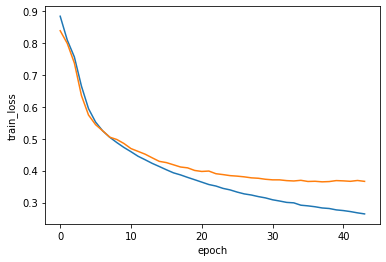

In [ ]:
visualizer(train_losses,valid_losses)

In [50]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [51]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [52]:
embedding_dim=300
hidden_dim=512
num_vocabs=len(tokens)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.2
model=BiLSTMClassificier(embedding_dim=embedding_dim,hidden_dim=hidden_dim,num_vocabs=num_vocabs,num_pos_tags=num_pos_tags,drop_rate=drop_rate)#,embedding_weights=weights)

In [53]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

In [54]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-35


In [55]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:
  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i['tokens'] for i in inputs],dtype=tf.int32)

  pos_tag_ids=tf.constant([i['pos_tags'] for i in inputs],dtype=tf.int32)
  
  
  logits=model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

In [56]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.89668   0.95502   0.92493      2290
           1    0.71790   0.69406   0.70578       572
           2    0.86395   0.87586   0.86986       145
           3    0.77778   0.13208   0.22581       159

    accuracy                        0.86292      3166
   macro avg    0.81408   0.66425   0.68159      3166
weighted avg    0.85691   0.86292   0.84770      3166

